In [1]:
# Import all libraries needed for the tutorial

# General syntax to import specific functions in a library: 
##from (library) import (specific library function)
from pandas import DataFrame, read_csv

# General syntax to import a library but no functions: 
##import (library) as (give the library a nickname/alias)
import matplotlib.pyplot as plt
import pandas as pd #this is how I usually import pandas
import sys #only needed to determine Python version number
import matplotlib #only needed to determine Matplotlib version number

# Enable inline plotting
%matplotlib inline

import scipy
import numpy as np
import scipy.signal as signal
from scipy.signal import *
import matplotlib.pyplot as plt

%matplotlib tk

In [36]:
#load data
# file path of csv file
#Location = r'/Users/33614/ExternalDrive/SUPAERO/PIR_2A/Data/data_spikes/E18KABaseline_Bcut.txt'
#Location = r'/Users/SYL21/D_Drive/SUPAERO/PIR_2A/Data/data_spikes/E18KABaseline_Bcut.txt'
#Location = r'/Users/louiseplacidet/Desktop/PIR/Data/data_spikes/E18KABaseline_Bcut.txt'
Location = r'/Users/louiseplacidet/Desktop/PIR/Data/new_spike_data/newdata/E18KABaseline_BcutV2groundAll.txt'
# create dataframe
df = pd.read_csv(Location, sep='\t',skiprows=[0,1,3] , index_col='%t           ')

In [37]:
#####################################################################################################################
####  BANK OF PARTS OF DATA

all_raw_data = df #Entire recording from all electrodes

full_signal = df.iloc[:,1] #Entire recording from the first electrode

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Sample rate and desired cutoff frequencies (in Hz).
fs = 25000.0
lowcut = 100.0
highcut = 2500.0


y = butter_bandpass_filter(df.iloc[:,1], lowcut, highcut, fs, order=6)


filtereddf = pd.DataFrame(y)
filtereddf.index = df.index

signal_filtered = filtereddf.iloc[:,0] #Entire recording filtered by bandpass, for one electrode


#fs = 25000

#xminnoise = int(np.round(11114*(fs/1000)))
#xmaxnoise = int(np.round(18511*(fs/1000)))

#noise_data = filtereddf.iloc[xminnoise:xmaxnoise,0]

#xminspike = int(np.round(130826*(fs/1000)))
#xmaxspike = int(np.round(131699*(fs/1000)))

#burst_data = filtereddf.iloc[xminspike:xmaxspike,0]

In [4]:
#threshold

def test_valid_window(window, test_level = 5):
    """
    window : the window in the signal that has to be tested
    
    This funtion test the window to insure that it doesn't contain the signal of interest (spike)
    """
    #non zero ?
    second = np.percentile(window, 2)
    thirtyth = np.percentile(window, 30)
    #print(str(second) + "\t" + str(thirtyth) + "\t" + str(second/thirtyth))
    if abs(second/thirtyth) < test_level : 
        return True
    else : 
        return False
    
def init_noise_levels(signal, fs, 
                      noise_window_size = 0.01,
                      required_valid_windows = 100,
                      old_noise_level_propagation = 0.8, 
                      test_level = 5,
                      estimator_type = "RMS",
                      percentile_value = 25):
    
    if estimator_type == "RMS":
        return init_noise_levels_RMS(signal, fs, 
                      noise_window_size = noise_window_size,
                      required_valid_windows = required_valid_windows,
                      old_noise_level_propagation = old_noise_level_propagation, 
                      test_level = test_level,
                      percentile_value = percentile_value)
        
    elif estimator_type == "MAD":
        return init_noise_levels_MAD(signal, fs, 
                      noise_window_size = noise_window_size,
                      required_valid_windows = required_valid_windows,
                      old_noise_level_propagation = old_noise_level_propagation, 
                      test_level = test_level,
                      percentile_value = percentile_value)
    
    else: return None
    
    
def init_noise_levels_RMS(signal, fs, 
                      noise_window_size = 0.01,
                      required_valid_windows = 100,
                      old_noise_level_propagation = 0.8, 
                      test_level = 5,
                      percentile_value = 25):
    
    nb_valid_windows = 0
    list_RMS = []
    noise_levels = []
    
    noise_level = -1
    
     
    #boucle en indice
#    for window_index in range(0,len(signal)-(len(signal)%int(fs*noise_window_size)),int(fs*noise_window_size)):
    for window_index in range(0,len(signal),int(fs*noise_window_size)):
        test = test_valid_window(signal.iloc[window_index: window_index + int(fs*noise_window_size)], test_level)
        if nb_valid_windows < required_valid_windows:
            if test == True :
                RMS = np.sqrt(np.mean(signal.iloc[window_index: window_index + int(fs*noise_window_size)]**2))
                list_RMS.append(RMS)
                nb_valid_windows += 1
            
            if nb_valid_windows == required_valid_windows:
                noise_level = np.percentile(list_RMS, percentile_value)
                for elm in range(0, window_index, int(fs*noise_window_size)):
                    noise_levels.append(noise_level)
                
        else :
            """if test == True:
                if (window + int(fs*noise_window_size)) > (len(signal)-1) :
                    N25 = np.percentile(abs(signal.iloc[window:]), 25)
                else :
                    N25 = np.percentile(abs(signal.iloc[window: window + int(fs*noise_window_size)]), 25)
                noise_level = old_noise_level_propagation*noise_level + (1-old_noise_level_propagation)*N25
            noise_levels.append(noise_level)"""
            if test == True:
                if (window_index + int(fs*noise_window_size)) > (len(signal)-1) :
                    RMS = np.sqrt(np.mean(signal.iloc[window_index:]**2))
                else :
                    RMS = np.sqrt(np.mean(signal.iloc[window_index: window_index + int(fs*noise_window_size)]**2))
                list_RMS.append(RMS)
                NX = np.percentile(list_RMS, percentile_value)
                new_noise_level = old_noise_level_propagation*noise_level + (1-old_noise_level_propagation)*NX
                noise_level = new_noise_level
            noise_levels.append(noise_level)
            
    #cas ou il n'y a pas eut 100 fenetres de bruit valides rencontrees
    if noise_level == -1:
        
        #cas ou aucune fenetre valide n'a ete rencontree
        if noise_levels == []:
            for elm in range(0, len(signal), int(fs*noise_window_size)):
                noise_levels.append(0)
            
        else:
            noise_level = np.percentile(list_RMS, percentile_value)
            for elm in range(0, len(signal), int(fs*noise_window_size)):
                noise_levels.append(noise_level)
        
    
    noise_levels.append(noise_level)        
    plt.figure()
    plt.plot(list_RMS)
    plt.xlabel('Time Windows')
    plt.title('RMS values')
    plt.grid(True)
                
    return noise_levels

def init_noise_levels_MAD(signal, fs, 
                      noise_window_size = 0.01,
                      required_valid_windows = 100,
                      old_noise_level_propagation = 0.8, 
                      test_level = 5,
                      percentile_value = 25):
    
    nb_valid_windows = 0
    list_MAD = []
    noise_levels = []
     
    #boucle en indice
    for window_index in range(0,len(signal),int(fs*noise_window_size)):
        test = test_valid_window(signal.iloc[window_index: window_index + int(fs*noise_window_size)], test_level)
        if nb_valid_windows < required_valid_windows:
            if test == True :
                ###RMS = np.sqrt(np.mean(signal.iloc[window_index: window_index + int(fs*noise_window_size)]**2))
                MAD = scipy.stats.median_absolute_deviation(signal.iloc[window_index: window_index + int(fs*noise_window_size)])
                list_MAD.append(MAD)
                nb_valid_windows += 1
            
            if nb_valid_windows == required_valid_windows:
                noise_level = np.percentile(list_MAD, percentile_value)
                for elm in range(0, window_index, int(fs*noise_window_size)):
                    noise_levels.append(noise_level)
                
        else :
            """if test == True:
                if (window + int(fs*noise_window_size)) > (len(signal)-1) :
                    N25 = np.percentile(abs(signal.iloc[window:]), 25)
                else :
                    N25 = np.percentile(abs(signal.iloc[window: window + int(fs*noise_window_size)]), 25)
                noise_level = old_noise_level_propagation*noise_level + (1-old_noise_level_propagation)*N25
            noise_levels.append(noise_level)"""
            if test == True:
                if (window_index + int(fs*noise_window_size)) > (len(signal)-1) :
                    ###RMS = np.sqrt(np.mean(signal.iloc[window_index:]**2))
                    MAD = scipy.stats.median_absolute_deviation(signal.iloc[window_index:])
                else :
                    ###RMS = np.sqrt(np.mean(signal.iloc[window_index: window_index + int(fs*noise_window_size)]**2))
                    MAD = scipy.stats.median_absolute_deviation(signal.iloc[window_index: window_index + int(fs*noise_window_size)])
                list_MAD.append(MAD)
                NX = np.percentile(list_MAD, percentile_value)
                new_noise_level = old_noise_level_propagation*noise_level + (1-old_noise_level_propagation)*NX
                noise_level = new_noise_level
            noise_levels.append(noise_level)
    
    noise_levels.append(noise_levels)        
    plt.figure()
    plt.plot(list_MAD)
    plt.xlabel('Time Windows')
    plt.title('MAD values')
    plt.grid(True)
                
    return noise_levels

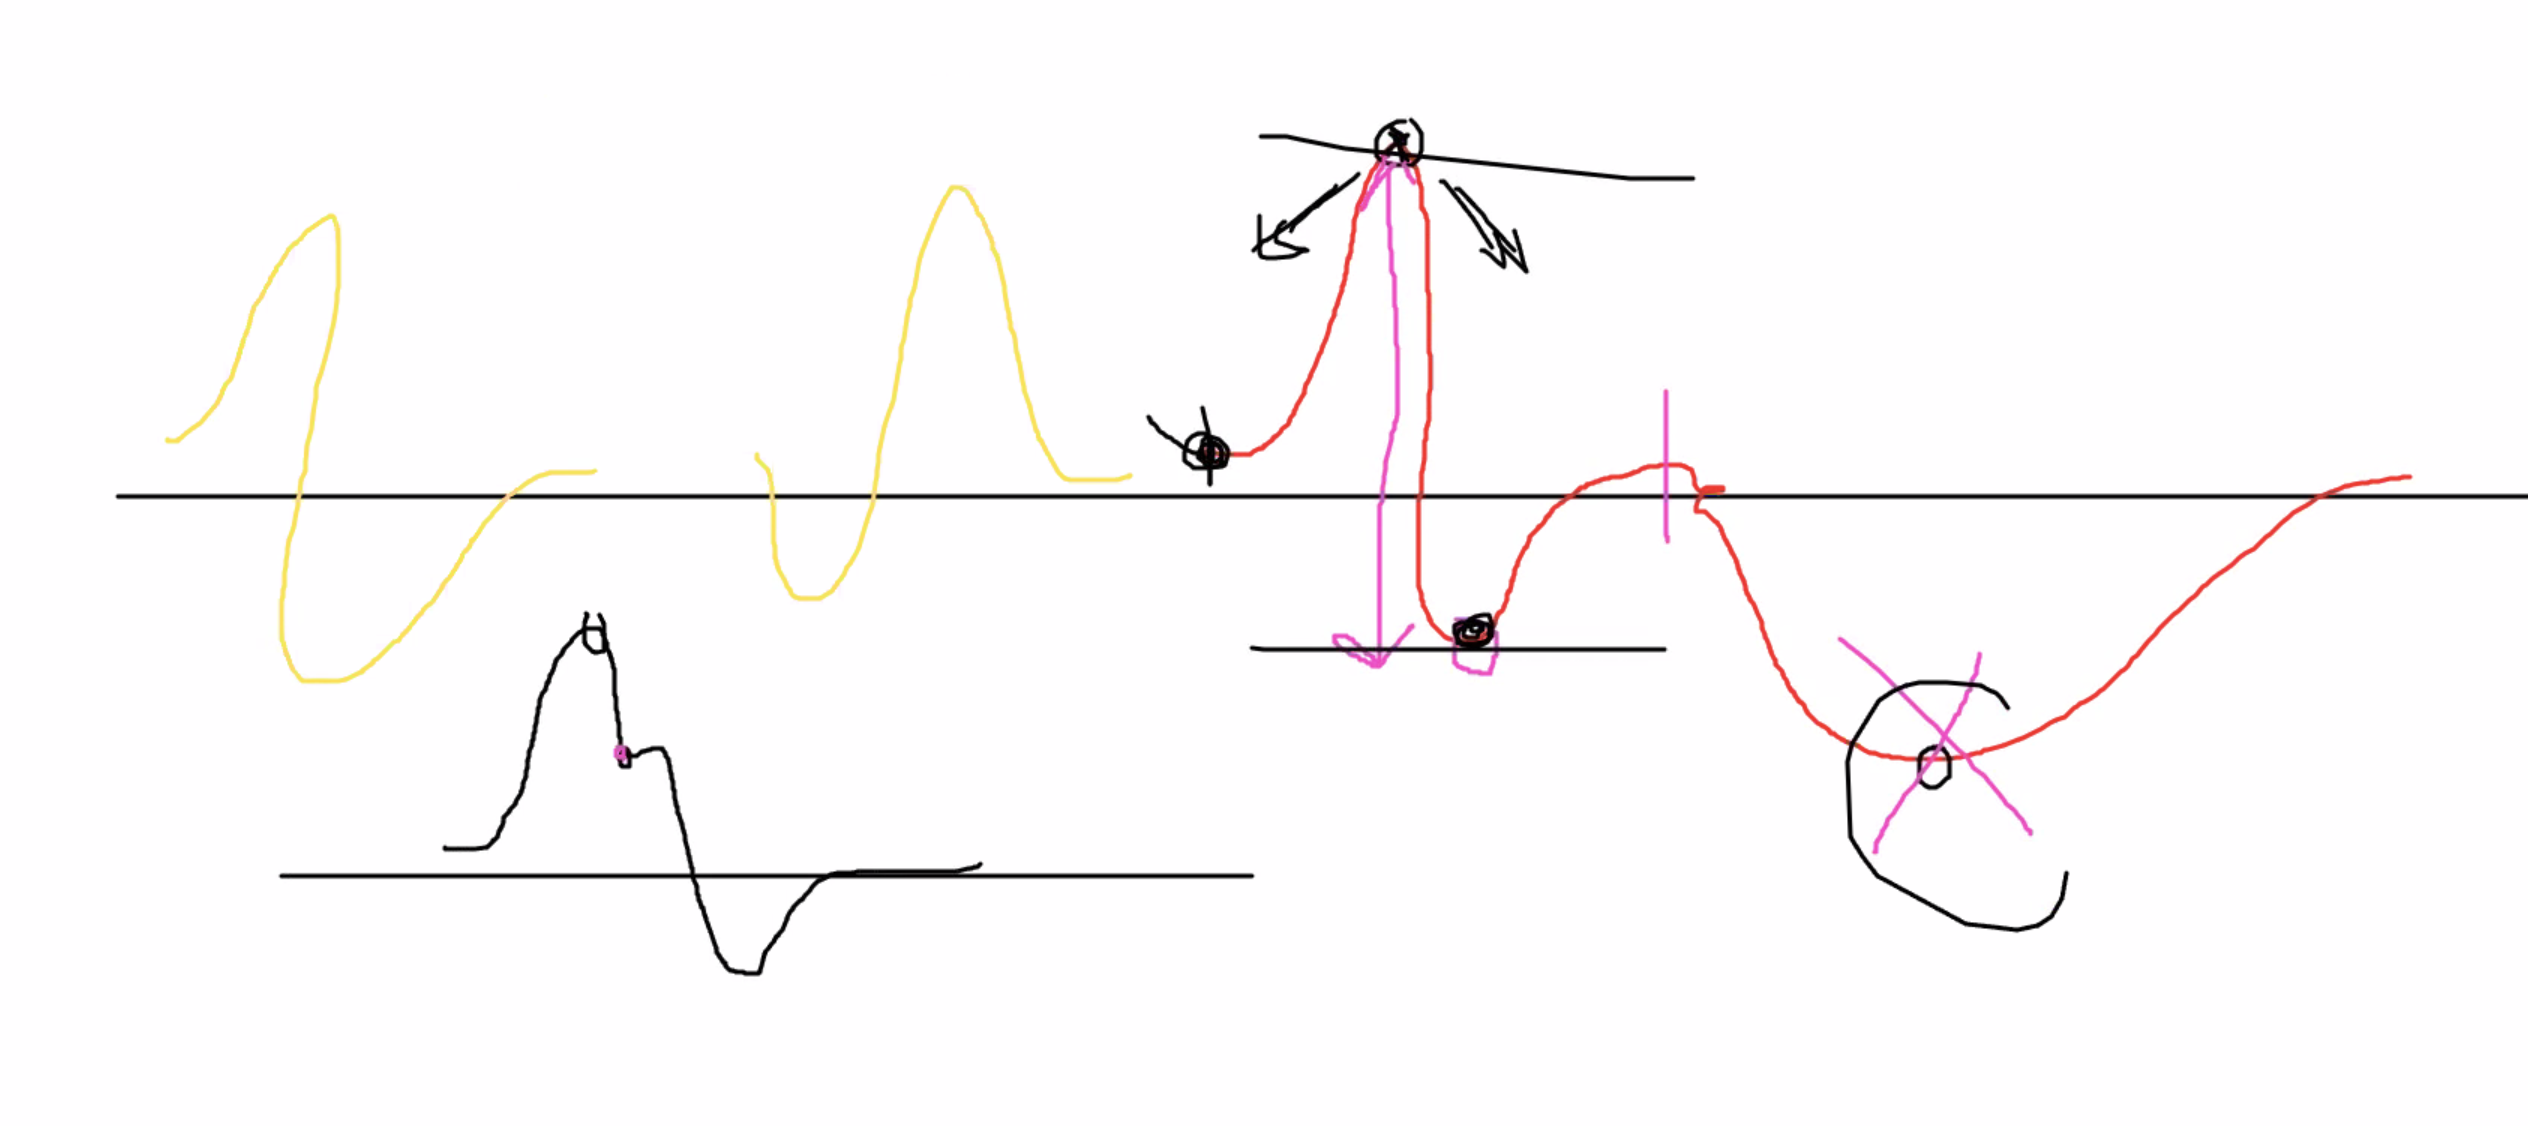

In [ ]:
#On trouve un extremum max ou min, et on prend une fenêtre à droite et à gauche, dans lequel on cherche l'extrêmum opposé
#On prend le plus grand extrêmum de ses deux fenêtres , et on garde la fenêtre
#On enregistre alors un array avec: l'indice du min, l'indice du max, la différence entre les indices, la différence
#    d'amplitude du min et du max, le point de premier dépassement positif et négatif
#On record, et on return l'indice du max+1ms comme ça, on se recentre sur le max avant de redéfini le mur de gauche


In [ ]:
#si on dépasse max threshold:
#    on prend fenêtre à droite et à gauche: jusqu'à trouver inversion de courbe+dépassement du -threshold
#    - soit on compare les mins des deux fenêtres pour prendre le plus grand en valeur absolue
#    - soit on compare les mins des deux fenêtres pour prendre le proche en valeur absolue
#Si on a balayé toute la fenêtre à droite et la fenêtre à gauche: c'est un artefact, donc on repousse jusqu'au mur de
#gauche et on recommence

In [39]:
#find spike

def find_spike(signal, initial_index, noise_levels, fs, spike_info, 
               window_size = 0.001, 
               noise_window_size = 0.01,
               threshold_factor = 3.5,
               maxseparation = 0.0008):
    
    offset_index = int(np.round(signal.index[0]*fs/1000))
    
    if initial_index < len(signal) + offset_index:
        i = initial_index
        for value in signal.iloc[initial_index-offset_index:]:
            threshold = threshold_factor*noise_levels[int(np.round((i/fs)//noise_window_size))]
            if value > threshold:
                while(True):
                    if i > initial_index + window_size*fs:
                        b_point = int(np.round(i - window_size*fs)) - offset_index
                    else :
                        b_point = initial_index - offset_index
                    if i < len(signal)+offset_index - window_size*fs-1:
                        e_point = int(np.round(i + window_size*fs)) - offset_index
                    else :
                        e_point = len(signal)

                    highest_value = signal.iloc[b_point: e_point].max()
                    
                    if highest_value == value : 
                        break
                    
                    else:
                        i = int(np.round(signal.iloc[b_point: e_point].idxmax()*fs/1000))
                        value = signal.iloc[i-offset_index] 
                
                
                
                if i == initial_index and i-offset_index-1>=0:
                    if signal.iloc[i-offset_index-1]>signal.iloc[i-offset_index]:
                        #décaler la limite de gauche jusqu'à la prochaine valeur en dessous du seuil
                        while signal.iloc[i-offset_index]>threshold:
                            i += 1
                        return i
                
                else:   
                    i_min = -1
                    #partir à la recherche d'un min du spike
                    for k in range(int(np.round(maxseparation*fs))):
                        if (i-offset_index+k) < len(signal)-1:
                            if signal.iloc[i-offset_index+k] < -threshold and signal.iloc[i-offset_index+k]<signal.iloc[i-offset_index+k+1]:
                                i_min = i+k
                                break
                        if (i-offset_index-k) > 0:
                            if signal.iloc[i-offset_index-k]<-threshold and signal.iloc[i-offset_index-k]<signal.iloc[i-offset_index-k-1]:
                                i_min = i-k
                                break
                    if i_min == -1:
                        #on a pas rencontré de spike
                        while signal.iloc[i-offset_index]>threshold:
                            i += 1
                        return i
                    else:
                        #récolte infos du spike
                             # indice max, indice min, distance entre max et min, variation d'amplitude entre min et max
                        spike_info.append([i, i_min, i-i_min, abs(signal.iloc[i-offset_index]-signal.iloc[i_min-offset_index])])
                        return i+int(np.round(window_size*fs))
                break  
            i += 1
    return -2

#vérifier que le deuxième extrêmum n'est pas collé au mur de gauche ni de droite
            
def find_spikes(signal, noise_levels, fs, 
               window_size = 0.001, 
               noise_window_size = 0.01,
               threshold_factor = 4,
               maxseparation = 0.0008):
    
    initial = int(np.round(signal.index[0]*fs/1000))
    spike_info = []
    
    while initial != -2:
        initial = find_spike(signal, initial, noise_levels, fs, spike_info,
                             window_size = window_size, 
                             noise_window_size = noise_window_size,
                             threshold_factor = threshold_factor)
    df_spike_info = pd.DataFrame(spike_info)
    return df_spike_info

In [40]:
#record spike

def record_spikes(signal, fs, spike_centers,
                  t_before = 0.001,
                  t_after = 0.002):
    
    data = np.array([[float(x) for x in range(int(np.round(fs*(t_before+t_after)))+1)]])
    
    initial_index = int(np.round(signal.index[0]*fs/1000))
    print('initial index:'+str(initial_index))
    
    for center in spike_centers:
        if center < int(np.round(fs*t_before)) + initial_index:
            spike = [0 for i in range(0, int(np.round(fs*t_before-(center-initial_index))))]
            #print('spike before concat:'+ str(len(spike)))
            #spike = np.concatenate(spike, signal.iloc[:center + int(np.round(fs*t_after))].values())
            spike = np.concatenate((spike, signal.values[:center + int(np.round(fs*t_after)) - initial_index]))
            #print('spike after concat:'+str(len(spike)))
            data = np.insert(data, len(data), spike, axis=0)
            
        elif center > int(np.round(len(signal)-fs*t_after)) + initial_index:
            #spike = signal.iloc[int(np.round(center-fs*t_before)):].values()
            spike = signal.values[int(np.round(center-fs*t_before))-initial_index:]
            #print('spike before concat:'+str(len(spike)))
            spike = np.concatenate((spike,[0 for i in range(0, int(np.round(fs*t_after-(len(signal)+initial_index-center))))]))
            #print('spike after concat:'+str(len(spike)))
            data = np.insert(data, len(data), spike, axis=0)
            
        else :
            #spike = signal.iloc[int(np.round(center - fs*t_before)): int(np.round(center + fs*t_after))+1].values()
            spike = signal.values[int(np.round(center - fs*t_before))-initial_index: int(np.round(center + fs*t_after))+1-initial_index]
            data = np.insert(data, len(data), spike, axis=0)

    print(np.shape(data))
    data = data.transpose()
    #print(data)
    spike_data = pd.DataFrame(data)
    
    return spike_data

In [41]:
def record_spikes_oneline(signal, fs, spike_centers,
                  t_before = 0.001,
                  t_after = 0.002):
    
    data = np.array(['NaN' for x in range(len(signal))])
    data = data.astype(float)
    times = np.array(['NaN' for x in range(len(signal))])
    times = times.astype(pd.Timestamp)
    
    for center in spike_centers:
        if center < int(np.round(fs*t_before)):
            data[:center + int(np.round(fs*t_after))] = signal.values[:center + int(np.round(fs*t_after))]
            times[:center + int(np.round(fs*t_after))] = signal.index[:center + int(np.round(fs*t_after))]
            
        elif center > int(np.round(len(signal)-fs*t_after)):
            data[int(np.round(center-fs*t_before)):] = signal.values[int(np.round(center-fs*t_before)):]
            times[int(np.round(center-fs*t_before)):] = signal.index[int(np.round(center-fs*t_before)):]
            
        else :
            data[int(np.round(center - fs*t_before)): int(np.round(center + fs*t_after))+1] = signal.values[int(np.round(center - fs*t_before)): int(np.round(center + fs*t_after))+1]
            times[int(np.round(center - fs*t_before)): int(np.round(center + fs*t_after))+1] = signal.index[int(np.round(center - fs*t_before)): int(np.round(center + fs*t_after))+1]

    spike_data_oneline = pd.DataFrame(data, index = times.astype(float))
    
    return spike_data_oneline

In [42]:
################################################################################################
####   TEST ADABANDFLT AVEC SIGNAL ORIGINAL (PASSE-BANDE+WIENER)

# Choices:
#  - full_signal : entire signal from first electrode
#  - signal_filtered : entire signal from first electrode after bandpass
#  - noise_data : part of signal where only noise (after bandpass)
#  - spike_data : part of signal where burst (after bandpass)


signal = signal_filtered

In [43]:
fs = 25000

noise_levels = init_noise_levels(signal_filtered, fs, 
                      noise_window_size = 0.01,
                      required_valid_windows = 100,
                      old_noise_level_propagation = 0.8, 
                      test_level = 5,
                      estimator_type = "RMS",
                      percentile_value = 25)


In [10]:
plt.figure()
plt.plot(noise_levels)
plt.grid(True)
plt.xlabel('Time')
plt.ylabel('Noise Amplitude [µV]')
plt.title('Noise Levels')

Text(0.5, 1.0, 'Noise Levels')

In [44]:
spike_info = find_spikes(signal, noise_levels, fs, 
                           window_size = 0.0008, 
                           noise_window_size = 0.01,
                           threshold_factor = 4,
                           maxseparation = 0.001)

spike_info

,0,1,2,3
0,53391,53382,9,18.693860
1,53492,53504,-12,31.926263
2,53590,53600,-10,23.809920
3,53645,53631,14,36.549054
4,53727,53717,10,24.989384
...,...,...,...,...
160,314032,314023,9,30.896503
161,314066,314059,7,17.946193
162,314097,314082,15,30.752795
163,314155,314143,12,37.294748


In [45]:
spike_data = record_spikes(signal, fs, spike_info.iloc[:,0], 
                  t_before = 0.0008, 
                  t_after = 0.0008)

initial index:0
(166, 41)


In [46]:
spike_data_oneline = record_spikes_oneline(signal, fs, spike_info.iloc[:,0],
                  t_before = 0.0008,
                  t_after = 0.0008)

In [47]:
#signal.plot(color = 'blue')
#spike_data_oneline.plot(color = 'red')
plt.plot(df.index, signal, color = 'blue')
plt.plot(spike_data_oneline.index, spike_data_oneline, color = 'red')
plt.title('Filtered Signal with Detected Spikes with RMS')
plt.xlabel('Time Windows')
plt.ylabel('Amplitude [µV]')
plt.legend()
plt.grid(True)

No handles with labels found to put in legend.
/opt/anaconda3/lib/python3.7/tkinter/__init__.py:749: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args)
/opt/anaconda3/lib/python3.7/tkinter/__init__.py:1705: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return self.func(*args)


In [32]:
plt.figure(figsize = (100,20))
#plt.plot(spike_data)
spike_data.iloc[:,1:].plot()
plt.xlabel('Time')
plt.grid()

In [ ]:
pca_data = np.array(spike_data.iloc[:,1:].values).transpose()

In [ ]:
y = [0 for i in range(len(pca_data))]
i=0
for data in pca_data:
    if data[25]>0:
        y[i]=1
    i+=1
    
fig = plt.figure(4, figsize=(4, 3))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()
pca = PCA(n_components=3)
pca.fit(pca_data)
X = pca.transform(pca_data)

# Reorder the labels to have colors matching the cluster results
y = np.choose(y, [1, 0]).astype(np.float)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap=plt.cm.nipy_spectral,
           edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

plt.show()